In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import mcu
import cylinder_dataset_generator as cyl
from importlib import reload

reload(mcu)
reload(cyl)

<module 'cylinder_dataset_generator' from 'C:\\Users\\einkina\\Documents\\School\\Manifold Learning\\manifold-learning\\cylinder_dataset_generator.py'>

In [ ]:
reload(cyl)
control_vars = cyl.get_control_vars()
response_matrix = cyl.generate_array_of_cylinders(control_vars, noise_level=0.05, num=100, num_points=200)
standardized_x, centered_y, edges, y_means, y_scaler, x_means, x_stds = mcu.prepare_data(control_vars, response_matrix)
q = mcu.solve_semidefinite_programming(standardized_x, centered_y, edges)

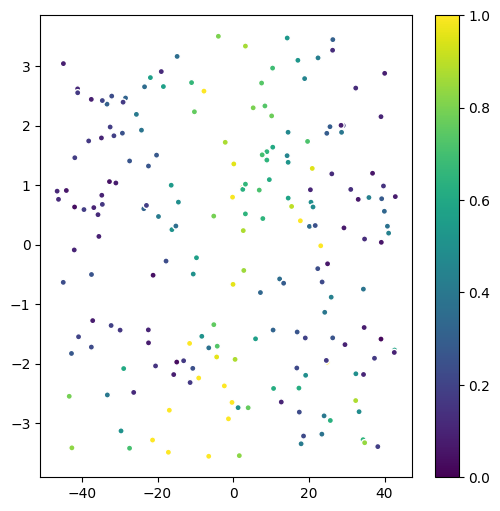

0.357665382385397


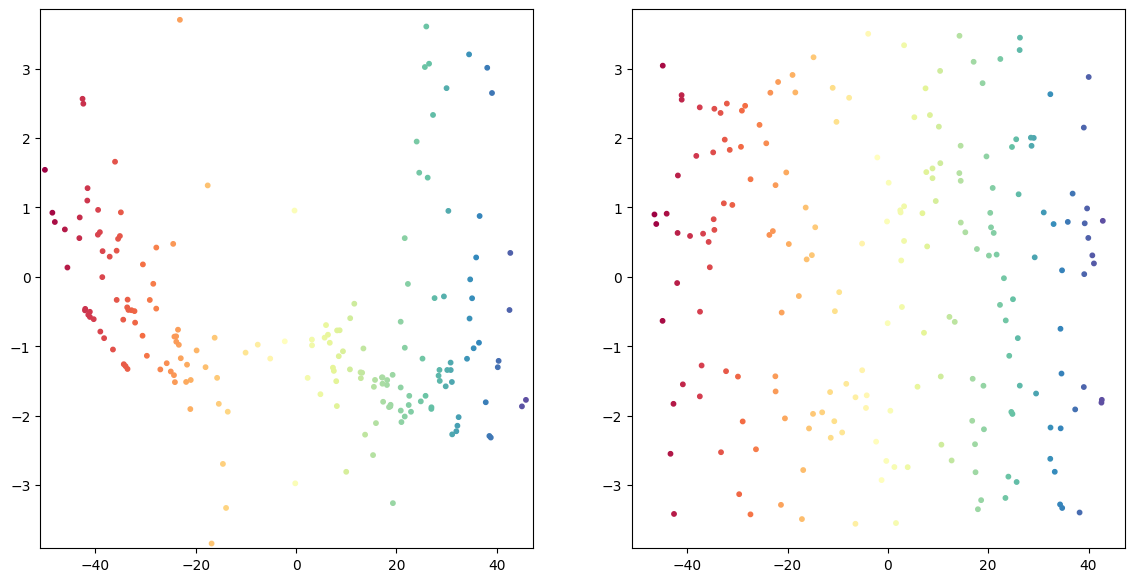

In [3]:
reload(mcu)
reload(cyl)
ld_embedding = mcu.reduce_dimensions(q)
regression_matrix = mcu.regress(ld_embedding, standardized_x)
reconstructed_y = np.dot(standardized_x, regression_matrix)

rre = mcu.compute_rre(ld_embedding, reconstructed_y)
mcu.plot_rre_heatmap(rre, reconstructed_y)
print(np.median(rre))
mcu.plot_two_embeddings(ld_embedding, reconstructed_y)

In [14]:
reload(mcu)
reload(cyl)
import random
test_control_vars = cyl.get_control_vars(1000)
test_rolls = cyl.generate_array_of_cylinders(test_control_vars, 0, 1000)
x_opts = []
for (roll, control_var) in zip(test_rolls, test_control_vars):
    # x_opt, x_err = mcu.predictive_optimization(roll, centered_y, ld_embedding, regression_matrix, y_means, y_scaler)
    # x_opt = x_opt * x_stds + x_means
    x_err = 0
    x_opt = (random.random()*10, random.random()*10)
    x_opts.append(x_opt)
    print("-----------")
    print(f"x_opt  = {x_opt}, x_err = {x_err}")
    print(f"x_real = {control_var}")

x_ops = np.array(x_opts)
test_control_vars = np.array(test_control_vars)

-----------
x_opt  = (8.786571046037775, 7.222585113634562), x_err = 0
x_real = [2.7361637513036428, 1.017121210204478]
-----------
x_opt  = (7.0786239950231264, 6.082388544206433), x_err = 0
x_real = [5.203740841753931, 4.418898531864625]
-----------
x_opt  = (0.7960238870475189, 4.36990174887247), x_err = 0
x_real = [4.1555013199850075, 2.5784780246943484]
-----------
x_opt  = (4.583650777217022, 2.7425804801168074), x_err = 0
x_real = [7.313457944690336, 4.353373316297836]
-----------
x_opt  = (8.673029395183253, 5.300534061817322), x_err = 0
x_real = [8.73257263332727, 2.6616407936590636]
-----------
x_opt  = (8.96427149967707, 8.881977814914894), x_err = 0
x_real = [5.593832254955865, 9.14839708608166]
-----------
x_opt  = (3.9442074772668456, 7.819211210683694), x_err = 0
x_real = [5.033066680826696, 6.897580046661976]
-----------
x_opt  = (9.162469466446815, 9.747787850357202), x_err = 0
x_real = [3.128319311272513, 9.469003126851735]
-----------
x_opt  = (9.893590389203306, 3.8

[ 8.66690318  2.5064688   3.80726773  3.16962154  2.63956494  3.38095252
  1.4265407   6.04058681  6.99812447  4.36509954  6.31547178  4.65631394
  3.3031924   3.25829409  9.33027957  9.52926094  7.1946979   0.64643868
  4.06939563  7.36691148  2.57180996  3.69863474  6.71449799  3.43338992
  5.79864112  9.00438629  9.10491863  7.81021514  3.42686911  5.42618598
  6.19462876  8.33789007  2.58531242  7.89624436  3.89160444  1.96045251
  7.66736323  6.11052208  5.66617831  7.52945491  9.13890105  7.62962093
  2.3683425   7.0061476   7.75018935  2.75124371  8.79407703  6.52120862
  8.09377666  4.34230319  7.94745401  0.61485143  7.37568367  7.05693238
  8.79655769  4.2069884   7.46572475  1.67526075  1.16324711  6.18950061
  4.88083288  8.12183302  1.7455025   3.66988257  0.89684012  6.34718804
  5.07253585  8.80341868  4.52890229  8.97797162  0.96390333  8.07887766
  7.83266288  7.94430504  2.11765716  7.22972195  4.46499097  6.94049046
  6.48125282  4.25455535  6.94851287  6.49810623  7

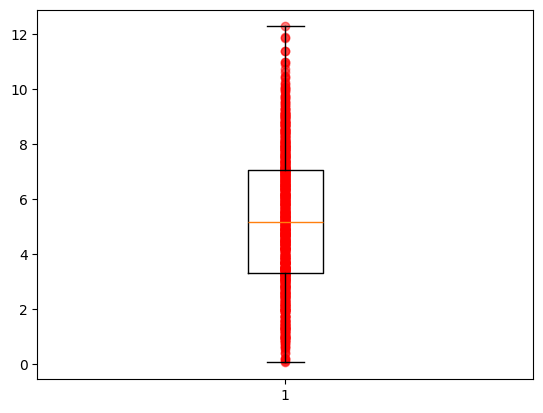

In [15]:
errors = np.linalg.norm(x_opts - test_control_vars, axis = 1)
plt.boxplot(errors)
plt.scatter(np.ones_like(errors), errors, alpha=0.5, color='red')
print(errors)
print(f"Median of errors = {np.median(errors)}")